In [1]:

from datetime import datetime

import torch
from torch.utils.data import DataLoader

from datasets.CSVDataset import CSVDataset
from models.mlp import MLPModel
from train import train_classifier
from utils import plot_model_metrics
from utils import reduce_dataset, split_dataset, undersample_dataset

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

batch_size = 128
dataset = CSVDataset("data/features/ResNet50_features.csv")
dataset = reduce_dataset(dataset, discard_ratio=0.0)
train_dataset, test_dataset = split_dataset(dataset, train_ratio=0.7)
train_dataset = undersample_dataset(train_dataset)

train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True)
test_loader = DataLoader(test_dataset,
                         batch_size=batch_size,
                         shuffle=True, )

model = MLPModel(in_features=2048, hidden_layers=2, neurons_per_layer=2048, dropout=0.4)
# dataset, _ = generate_balanced_dataset("features/ResNet50_features.csv", discard_ratio=0.9, test_ratio=0,
#                                        undersample=False)

print(f"Dataset: {len(train_dataset):,} training, {len(test_dataset):,} testing")


Device: cuda:0
data/features/ResNet50_features.pickle
Dataset: 276,448 training, 118,478 testing


In [2]:
print(model)

MLPModel(
  (model): Sequential(
    (0): Linear(in_features=2048, out_features=2048, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=2048, out_features=2048, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.4, inplace=False)
    (6): Linear(in_features=2048, out_features=2048, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.4, inplace=False)
    (9): Linear(in_features=2048, out_features=1, bias=True)
    (10): Sigmoid()
  )
)


In [3]:
print(f"Training starts {datetime.now().isoformat()}")

Training starts 2024-09-03T12:45:48.331998


In [4]:

model = model.to(device)
model, model_metrics = train_classifier(model, train_loader, test_loader, device,
                                        learning_rate=0.0001,
                                        max_epochs=50,
                                        checkpoint_every=None,
                                        eval_every=1)


Epoch 1 training: 100%|██████████| 2160/2160 [00:05<00:00, 415.42it/s]


Train: 1/50: loss:0.18535450427379047


Epoch 1 testing: 100%|██████████| 926/926 [00:01<00:00, 820.33it/s]


Test: 1/50: loss:0.11022503631788891, accuracy:0.9563937288863046, precision:0.9285155478399002, recall:0.9153551009647767, f1:0.9208397877880519, mcc:0.8914712566349954, epoch:0


Epoch 2 training: 100%|██████████| 2160/2160 [00:05<00:00, 364.75it/s]


Train: 2/50: loss:0.09918312224973407


Epoch 2 testing: 100%|██████████| 926/926 [00:01<00:00, 600.79it/s]


Test: 2/50: loss:0.08176445684719581, accuracy:0.9686446478512487, precision:0.9370517487650493, recall:0.9522456644864584, f1:0.9438509790415601, mcc:0.9226443170574841, epoch:1


Epoch 3 training: 100%|██████████| 2160/2160 [00:05<00:00, 361.79it/s]


Train: 3/50: loss:0.0757662160378122


Epoch 3 testing: 100%|██████████| 926/926 [00:01<00:00, 613.70it/s]


Test: 3/50: loss:0.07378801263740073, accuracy:0.971889147906629, precision:0.9500902269637177, recall:0.9501176030612078, f1:0.9494070965877821, mcc:0.9304143911803393, epoch:2


Epoch 4 training: 100%|██████████| 2160/2160 [00:05<00:00, 360.09it/s]


Train: 4/50: loss:0.06279649801112505


Epoch 4 testing: 100%|██████████| 926/926 [00:01<00:00, 626.91it/s]


Test: 4/50: loss:0.06539472958000606, accuracy:0.9752463552915767, precision:0.964996067802381, recall:0.9459723778424214, f1:0.9547995350029639, mcc:0.9382146864605675, epoch:3


Epoch 5 training: 100%|██████████| 2160/2160 [00:06<00:00, 359.50it/s]


Train: 5/50: loss:0.05264252120935082


Epoch 5 testing: 100%|██████████| 926/926 [00:01<00:00, 616.12it/s]


Test: 5/50: loss:0.06728016734062885, accuracy:0.9750131527939303, precision:0.9421129286242399, recall:0.970796852250326, f1:0.955648663365898, mcc:0.9388396011880665, epoch:4


Epoch 6 training: 100%|██████████| 2160/2160 [00:05<00:00, 404.05it/s]


Train: 6/50: loss:0.04522079799919286


Epoch 6 testing: 100%|██████████| 926/926 [00:01<00:00, 616.00it/s]


Test: 6/50: loss:0.06393136592460173, accuracy:0.9775664821814255, precision:0.9578824975764747, recall:0.9626471883344029, f1:0.9597350254506825, mcc:0.9445307115481312, epoch:5


Epoch 7 training: 100%|██████████| 2160/2160 [00:05<00:00, 408.06it/s]


Train: 7/50: loss:0.03900482931187273


Epoch 7 testing: 100%|██████████| 926/926 [00:01<00:00, 608.78it/s]


Test: 7/50: loss:0.063973094073434, accuracy:0.978486096112311, precision:0.9617660544891131, recall:0.9614116862985366, f1:0.9610939264781867, mcc:0.9465275088092351, epoch:6


Epoch 8 training: 100%|██████████| 2160/2160 [00:05<00:00, 401.52it/s]


Train: 8/50: loss:0.03465155764042046


Epoch 8 testing: 100%|██████████| 926/926 [00:01<00:00, 608.66it/s]


Test: 8/50: loss:0.05982902307152853, accuracy:0.9790496327601484, precision:0.9639445595151671, recall:0.9616736188201005, f1:0.9622925344894739, mcc:0.9481356006672781, epoch:7


Epoch 9 training: 100%|██████████| 2160/2160 [00:05<00:00, 383.85it/s]


Train: 9/50: loss:0.03053510035113302


Epoch 9 testing: 100%|██████████| 926/926 [00:01<00:00, 611.60it/s]


Test: 9/50: loss:0.06787249935613884, accuracy:0.9769873698565653, precision:0.94838452579501, recall:0.9710186450531609, f1:0.9590076112349412, mcc:0.9435092109788851, epoch:8


Epoch 10 training: 100%|██████████| 2160/2160 [00:05<00:00, 366.76it/s]


Train: 10/50: loss:0.028452998149306814


Epoch 10 testing: 100%|██████████| 926/926 [00:01<00:00, 608.73it/s]


Test: 10/50: loss:0.059491266759985464, accuracy:0.9793888363930886, precision:0.9661880455961324, recall:0.9597850690715299, f1:0.962432473018009, mcc:0.9485967427393885, epoch:9


Epoch 11 training: 100%|██████████| 2160/2160 [00:05<00:00, 384.31it/s]


Train: 11/50: loss:0.025245658449798442


Epoch 11 testing: 100%|██████████| 926/926 [00:01<00:00, 610.00it/s]


Test: 11/50: loss:0.06728207436886809, accuracy:0.9789001495264994, precision:0.9559921394281756, recall:0.9696600120805591, f1:0.9622536173534633, mcc:0.948010669223812, epoch:10


Epoch 12 training: 100%|██████████| 2160/2160 [00:05<00:00, 366.15it/s]


Train: 12/50: loss:0.023308493434780284


Epoch 12 testing: 100%|██████████| 926/926 [00:01<00:00, 601.11it/s]


Test: 12/50: loss:0.06706613506686815, accuracy:0.9795244745804951, precision:0.9646097418596106, recall:0.9624369981121123, f1:0.963019858974039, mcc:0.9491808167846352, epoch:11


Epoch 13 training: 100%|██████████| 2160/2160 [00:05<00:00, 396.26it/s]


Train: 13/50: loss:0.021060376975718234


Epoch 13 testing: 100%|██████████| 926/926 [00:01<00:00, 616.47it/s]


Test: 13/50: loss:0.06569793345064698, accuracy:0.9798788212327629, precision:0.9668621262091425, recall:0.961138102686528, f1:0.963500561307461, mcc:0.9499384279745166, epoch:12


Epoch 14 training: 100%|██████████| 2160/2160 [00:05<00:00, 403.66it/s]


Train: 14/50: loss:0.01968764566689195


Epoch 14 testing: 100%|██████████| 926/926 [00:01<00:00, 611.57it/s]


Test: 14/50: loss:0.06438889494945232, accuracy:0.9809189303317273, precision:0.9728067586304996, recall:0.9588324913853705, f1:0.9652936047043058, mcc:0.9524895559974235, epoch:13


Epoch 15 training: 100%|██████████| 2160/2160 [00:05<00:00, 404.17it/s]


Train: 15/50: loss:0.018009516206637745


Epoch 15 testing: 100%|██████████| 926/926 [00:01<00:00, 615.14it/s]


Test: 15/50: loss:0.07466567997540574, accuracy:0.9785765215705821, precision:0.957377604357436, recall:0.9670427190151343, f1:0.9616610549267425, mcc:0.9471613038773793, epoch:14


Epoch 16 training: 100%|██████████| 2160/2160 [00:05<00:00, 403.53it/s]


Train: 16/50: loss:0.01724233411748207


Epoch 16 testing: 100%|██████████| 926/926 [00:01<00:00, 612.61it/s]


Test: 16/50: loss:0.0745899005367855, accuracy:0.9796311247023315, precision:0.9671947903975856, recall:0.9604863035828702, f1:0.9633037546708839, mcc:0.9495669110884734, epoch:15


Epoch 17 training: 100%|██████████| 2160/2160 [00:05<00:00, 402.74it/s]


Train: 17/50: loss:0.01564917141852978


Epoch 17 testing: 100%|██████████| 926/926 [00:01<00:00, 621.08it/s]


Test: 17/50: loss:0.06992019326240026, accuracy:0.9801228401727862, precision:0.9709995943544694, recall:0.958048608103142, f1:0.963963763540809, mcc:0.9506315647234077, epoch:16


Epoch 18 training: 100%|██████████| 2160/2160 [00:05<00:00, 404.26it/s]


Train: 18/50: loss:0.014806993333621466


Epoch 18 testing: 100%|██████████| 926/926 [00:01<00:00, 618.10it/s]


Test: 18/50: loss:0.07669857656539189, accuracy:0.9803145075317052, precision:0.9589018631651107, recall:0.9717118815590587, f1:0.9647462269804389, mcc:0.9514721706779595, epoch:17


Epoch 19 training: 100%|██████████| 2160/2160 [00:05<00:00, 403.75it/s]


Train: 19/50: loss:0.014623376293884913


Epoch 19 testing: 100%|██████████| 926/926 [00:01<00:00, 609.36it/s]


Test: 19/50: loss:0.07412106086717231, accuracy:0.97955216467298, precision:0.9562757608566992, recall:0.9714568086922951, f1:0.9633204773684365, mcc:0.9495177382171734, epoch:18


Epoch 20 training: 100%|██████████| 2160/2160 [00:05<00:00, 402.89it/s]


Train: 20/50: loss:0.013847608630944537


Epoch 20 testing: 100%|██████████| 926/926 [00:01<00:00, 619.09it/s]


Test: 20/50: loss:0.06853037823676021, accuracy:0.9810002699784017, precision:0.96557463415456, recall:0.966887040894038, f1:0.9657437692205453, mcc:0.9529203890568007, epoch:19


Epoch 21 training: 100%|██████████| 2160/2160 [00:05<00:00, 401.65it/s]


Train: 21/50: loss:0.012921275914885445


Epoch 21 testing: 100%|██████████| 926/926 [00:01<00:00, 619.96it/s]


Test: 21/50: loss:0.07547387829882742, accuracy:0.9811605696544277, precision:0.9691605776832215, recall:0.9638971677474008, f1:0.9660804019431927, mcc:0.9533365969431942, epoch:20


Epoch 22 training: 100%|██████████| 2160/2160 [00:05<00:00, 384.07it/s]


Train: 22/50: loss:0.012128151705413377


Epoch 22 testing: 100%|██████████| 926/926 [00:01<00:00, 584.57it/s]


Test: 22/50: loss:0.07700274554168007, accuracy:0.9812142192086171, precision:0.9713370323663217, recall:0.9614377150784734, f1:0.9658747655254737, mcc:0.9532685384741245, epoch:21


Epoch 23 training: 100%|██████████| 2160/2160 [00:05<00:00, 365.20it/s]


Train: 23/50: loss:0.011929951926174033


Epoch 23 testing: 100%|██████████| 926/926 [00:01<00:00, 600.78it/s]


Test: 23/50: loss:0.08470711561110847, accuracy:0.9797293379991139, precision:0.9772372357057414, recall:0.9500271904014962, f1:0.9629461477631123, mcc:0.949495086494339, epoch:22


Epoch 24 training: 100%|██████████| 2160/2160 [00:05<00:00, 360.69it/s]


Train: 24/50: loss:0.011033744713923052


Epoch 24 testing: 100%|██████████| 926/926 [00:01<00:00, 615.70it/s]


Test: 24/50: loss:0.0863693599477531, accuracy:0.9796280960984659, precision:0.9617101035287905, recall:0.9658070213612652, f1:0.9633050023349046, mcc:0.9494755025065251, epoch:23


Epoch 25 training: 100%|██████████| 2160/2160 [00:05<00:00, 363.61it/s]


Train: 25/50: loss:0.01093257062082692


Epoch 25 testing: 100%|██████████| 926/926 [00:01<00:00, 603.22it/s]


Test: 25/50: loss:0.08722406495589756, accuracy:0.980803843384837, precision:0.9703688925079347, recall:0.9611793166879086, f1:0.9652496977257193, mcc:0.952357690228504, epoch:24


Epoch 26 training: 100%|██████████| 2160/2160 [00:05<00:00, 362.83it/s]


Train: 26/50: loss:0.0106479203577456


Epoch 26 testing: 100%|██████████| 926/926 [00:01<00:00, 610.70it/s]


Test: 26/50: loss:0.08711196052142596, accuracy:0.9797070561278175, precision:0.9526059991357835, recall:0.9765406540481466, f1:0.9639426714030667, mcc:0.9502759996241897, epoch:25


Epoch 27 training: 100%|██████████| 2160/2160 [00:05<00:00, 388.27it/s]


Train: 27/50: loss:0.009798278748953466


Epoch 27 testing: 100%|██████████| 926/926 [00:01<00:00, 606.39it/s]


Test: 27/50: loss:0.07683136241228697, accuracy:0.9805561468544054, precision:0.9667894771540136, recall:0.9641522868933611, f1:0.9649916402596589, mcc:0.951843515644696, epoch:26


Epoch 28 training: 100%|██████████| 2160/2160 [00:05<00:00, 398.66it/s]


Train: 28/50: loss:0.009933670632864489


Epoch 28 testing: 100%|██████████| 926/926 [00:01<00:00, 608.50it/s]


Test: 28/50: loss:0.08809624027865344, accuracy:0.9804073126072992, precision:0.9580828239438394, recall:0.9725986549535014, f1:0.9647784031775671, mcc:0.9516078692637333, epoch:27


Epoch 29 training: 100%|██████████| 2160/2160 [00:05<00:00, 405.81it/s]


Train: 29/50: loss:0.009556448629424537


Epoch 29 testing: 100%|██████████| 926/926 [00:01<00:00, 603.03it/s]


Test: 29/50: loss:0.08404578043174449, accuracy:0.9806995728803234, precision:0.9645500201626678, recall:0.9667865923563325, f1:0.9651956500477376, mcc:0.9521549595626148, epoch:28


Epoch 30 training: 100%|██████████| 2160/2160 [00:05<00:00, 407.33it/s]


Train: 30/50: loss:0.008863279820148078


Epoch 30 testing: 100%|██████████| 926/926 [00:01<00:00, 590.78it/s]


Test: 30/50: loss:0.08823321871841669, accuracy:0.979777579332115, precision:0.9698809224135694, recall:0.9578955918561578, f1:0.9633355682759261, mcc:0.9497620164238983, epoch:29


Epoch 31 training: 100%|██████████| 2160/2160 [00:06<00:00, 357.09it/s]


Train: 31/50: loss:0.008392312484967853


Epoch 31 testing: 100%|██████████| 926/926 [00:02<00:00, 352.71it/s]


Test: 31/50: loss:0.08417681864653634, accuracy:0.9813184897131306, precision:0.9704290872795684, recall:0.9628486905715384, f1:0.9661445278683205, mcc:0.9535772604396409, epoch:30


Epoch 32 training: 100%|██████████| 2160/2160 [00:08<00:00, 245.74it/s]


Train: 32/50: loss:0.008542915906525228


Epoch 32 testing: 100%|██████████| 926/926 [00:02<00:00, 358.65it/s]


Test: 32/50: loss:0.08320576482438058, accuracy:0.981492634435399, precision:0.9679458041507456, recall:0.9662269407456102, f1:0.966650734112276, mcc:0.9541110872300642, epoch:31


Epoch 33 training: 100%|██████████| 2160/2160 [00:08<00:00, 246.24it/s]


Train: 33/50: loss:0.008183789149110773


Epoch 33 testing: 100%|██████████| 926/926 [00:02<00:00, 366.18it/s]


Test: 33/50: loss:0.08404880091009419, accuracy:0.9813208693304536, precision:0.9641847978801766, recall:0.9697649680090802, f1:0.9664878199830494, mcc:0.953861684400056, epoch:32


Epoch 34 training: 100%|██████████| 2160/2160 [00:08<00:00, 247.11it/s]


Train: 34/50: loss:0.008043509078199215


Epoch 34 testing: 100%|██████████| 926/926 [00:02<00:00, 362.18it/s]


Test: 34/50: loss:0.08478399477042932, accuracy:0.9803597202608406, precision:0.9632937000386568, recall:0.9665069802376683, f1:0.9644040401545781, mcc:0.9511714131820985, epoch:33


Epoch 35 training: 100%|██████████| 2160/2160 [00:08<00:00, 253.58it/s]


Train: 35/50: loss:0.008026254805300235


Epoch 35 testing: 100%|██████████| 926/926 [00:01<00:00, 592.06it/s]


Test: 35/50: loss:0.08603365745277687, accuracy:0.9819789416846653, precision:0.9703040771021909, recall:0.9653789626330405, f1:0.9673710813420663, mcc:0.9552401880443744, epoch:34


Epoch 36 training: 100%|██████████| 2160/2160 [00:05<00:00, 385.45it/s]


Train: 36/50: loss:0.007523143158556212


Epoch 36 testing: 100%|██████████| 926/926 [00:01<00:00, 603.77it/s]


Test: 36/50: loss:0.07991140111716055, accuracy:0.9813238979343191, precision:0.9668979178225516, recall:0.9664798263306885, f1:0.9661939428739843, mcc:0.9536196390404922, epoch:35


Epoch 37 training: 100%|██████████| 2160/2160 [00:05<00:00, 394.95it/s]


Train: 37/50: loss:0.007393865642766455


Epoch 37 testing: 100%|██████████| 926/926 [00:01<00:00, 612.90it/s]


Test: 37/50: loss:0.09077055415570257, accuracy:0.9801373342055713, precision:0.9555177783230697, recall:0.9750335271769636, f1:0.9647247374580608, mcc:0.9512741830397908, epoch:36


Epoch 38 training: 100%|██████████| 2160/2160 [00:05<00:00, 371.75it/s]


Train: 38/50: loss:0.007371758657346719


Epoch 38 testing: 100%|██████████| 926/926 [00:01<00:00, 601.38it/s]


Test: 38/50: loss:0.0819254103127063, accuracy:0.9816897100155065, precision:0.964330673794259, recall:0.9711069577450931, f1:0.9672847858981847, mcc:0.9548610060580999, epoch:37


Epoch 39 training: 100%|██████████| 2160/2160 [00:05<00:00, 386.17it/s]


Train: 39/50: loss:0.00731729729357253


Epoch 39 testing: 100%|██████████| 926/926 [00:01<00:00, 605.27it/s]


Test: 39/50: loss:0.08642534232311105, accuracy:0.9818523893088553, precision:0.9674172038399481, recall:0.967803913007735, f1:0.9671853764666699, mcc:0.954904110411219, epoch:38


Epoch 40 training: 100%|██████████| 2160/2160 [00:06<00:00, 354.52it/s]


Train: 40/50: loss:0.00692851754760829


Epoch 40 testing: 100%|██████████| 926/926 [00:01<00:00, 610.22it/s]


Test: 40/50: loss:0.08195570981852476, accuracy:0.981819290995182, precision:0.9650155113344959, recall:0.9705992350119491, f1:0.9673290898813232, mcc:0.9550602422088748, epoch:39


Epoch 41 training: 100%|██████████| 2160/2160 [00:05<00:00, 363.32it/s]


Train: 41/50: loss:0.006454235626956288


Epoch 41 testing: 100%|██████████| 926/926 [00:01<00:00, 611.72it/s]


Test: 41/50: loss:0.094614262918955, accuracy:0.981349208409481, precision:0.9602289856409761, recall:0.9740012219616431, f1:0.9666158198890841, mcc:0.9540288444287165, epoch:40


Epoch 42 training: 100%|██████████| 2160/2160 [00:05<00:00, 399.34it/s]


Train: 42/50: loss:0.006294435319669581


Epoch 42 testing: 100%|██████████| 926/926 [00:01<00:00, 594.24it/s]


Test: 42/50: loss:0.09550155694840756, accuracy:0.9818891652129368, precision:0.9729923038895395, recall:0.9621273801310887, f1:0.9670671830721789, mcc:0.9549123768455787, epoch:41


Epoch 43 training: 100%|██████████| 2160/2160 [00:05<00:00, 370.08it/s]


Train: 43/50: loss:0.006325248532409997


Epoch 43 testing: 100%|██████████| 926/926 [00:01<00:00, 610.53it/s]


Test: 43/50: loss:0.09223663028716259, accuracy:0.9814305480561555, precision:0.9628688560710165, recall:0.9717660121243648, f1:0.9668574285940451, mcc:0.9542796111036462, epoch:42


Epoch 44 training: 100%|██████████| 2160/2160 [00:05<00:00, 390.92it/s]


Train: 44/50: loss:0.006432327352979849


Epoch 44 testing: 100%|██████████| 926/926 [00:01<00:00, 611.04it/s]


Test: 44/50: loss:0.08336840836046748, accuracy:0.9823194432906905, precision:0.9704721133711869, recall:0.9666417993029683, f1:0.9681076008774926, mcc:0.9561803178430843, epoch:43


Epoch 45 training: 100%|██████████| 2160/2160 [00:05<00:00, 394.54it/s]


Train: 45/50: loss:0.0060190769624949994


Epoch 45 testing: 100%|██████████| 926/926 [00:01<00:00, 573.03it/s]


Test: 45/50: loss:0.09160815594340013, accuracy:0.9816390890651825, precision:0.9651165987868096, recall:0.9696432322739248, f1:0.9668998008882979, mcc:0.9545221731341178, epoch:44


Epoch 46 training: 100%|██████████| 2160/2160 [00:05<00:00, 385.89it/s]


Train: 46/50: loss:0.006201844278543452


Epoch 46 testing: 100%|██████████| 926/926 [00:01<00:00, 607.59it/s]


Test: 46/50: loss:0.0974906895379704, accuracy:0.9815601290358309, precision:0.973097367795146, recall:0.9609144176896888, f1:0.9665345374618158, mcc:0.9541367600712578, epoch:45


Epoch 47 training: 100%|██████████| 2160/2160 [00:05<00:00, 384.32it/s]


Train: 47/50: loss:0.005931428880893674


Epoch 47 testing: 100%|██████████| 926/926 [00:01<00:00, 609.53it/s]


Test: 47/50: loss:0.10567070773881146, accuracy:0.9804049329899762, precision:0.9779359290646018, recall:0.9517881285586594, f1:0.9641926117000991, mcc:0.9512057888297483, epoch:46


Epoch 48 training: 100%|██████████| 2160/2160 [00:05<00:00, 387.28it/s]


Train: 48/50: loss:0.006249228143666077


Epoch 48 testing: 100%|██████████| 926/926 [00:01<00:00, 610.07it/s]


Test: 48/50: loss:0.0920135125340472, accuracy:0.9819367575593952, precision:0.9723627739299946, recall:0.9632796985961152, f1:0.9673841564250714, mcc:0.9551681080065144, epoch:47


Epoch 49 training: 100%|██████████| 2160/2160 [00:05<00:00, 379.73it/s]


Train: 49/50: loss:0.005785823513918718


Epoch 49 testing: 100%|██████████| 926/926 [00:01<00:00, 594.60it/s]


Test: 49/50: loss:0.08920469493798645, accuracy:0.9816390890651825, precision:0.9740967881850807, recall:0.9602873997541711, f1:0.9666910074834664, mcc:0.9543559225681884, epoch:48


Epoch 50 training: 100%|██████████| 2160/2160 [00:05<00:00, 391.02it/s]


Train: 50/50: loss:0.0054973659486287725


Epoch 50 testing: 100%|██████████| 926/926 [00:01<00:00, 595.72it/s]

Test: 50/50: loss:0.10324305265202115, accuracy:0.9813944211386166, precision:0.9670963354039609, recall:0.9664175438528899, f1:0.9663215096087691, mcc:0.9537474976621929, epoch:49


Training ends 2024-09-03T12:52:02.047384
Test accuracy: 0.9813944211386166
Test precision: 0.9670963354039609
Test recall: 0.9664175438528899
Test f1: 0.9663215096087691
Test mcc: 0.9537474976621929


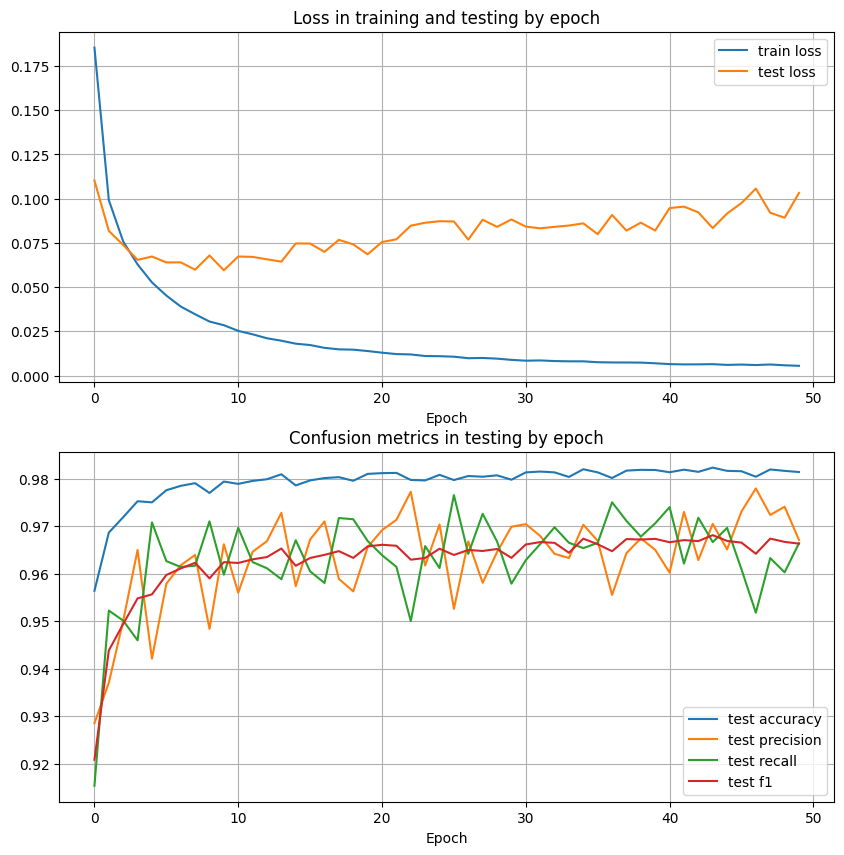

In [5]:

print(f"Training ends {datetime.now().isoformat()}")
for metric in ["accuracy", "precision", "recall", "f1", "mcc"]:
    if len(model_metrics[f"test_{metric}"]) > 0:
        print(f"Test {metric}:", model_metrics[f"test_{metric}"][-1])

plot_model_metrics(model_metrics)